In [52]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import keras 
import datetime
import requests
import warnings
import keras

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

In [53]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['model', 'mae', 'mase', 'rsq'])

# Pre-processing

In [54]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()
df

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Belgium,location_Chile,location_Czechia,location_Estonia,location_France,location_Ireland,location_Israel,location_Italy,location_Malaysia,location_United States
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-01,16.0,0.0,0.0,0.248,0.000,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2020-03-01,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.395,2.372,NaN,...,0,0,0,0,0,1,0,0,0,0
2020-03-01,NaN,0.0,0.0,NaN,0.000,0.000,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2020-03-01,15.0,5.0,0.0,1.587,0.529,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,4848745.0,0.0,0.0,415989.793,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2024-01-07,103436829.0,NaN,0.0,305763.910,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2024-01-14,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0


In [55]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 
def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [56]:
df=process(df)
df=normalize(df)
df.shape

(20209, 68)

In [57]:
def make_series(data):
    series=[]
    for i in range(len(data)-13):
        subdf=data[i:i+13]
        series.append( (subdf.index[-1], subdf['new_deaths'].values[-1], subdf.drop('new_deaths', axis=1).values))
    return series
series=make_series(df)
print(series[0][0],series[0][1].shape,series[0][2].shape)
train_size = int(len(series) * 0.7)
train, test = series[0:train_size], series[train_size:]
#train=series[:-30]
#test=series[-30:]

# Attempt 1

## Training

In [ ]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [ ]:
inputs = keras.layers.Input(shape=(13,67))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 13, 67)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12800     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14137, 13, 67)
(14137,)
Epoch 1/50
442/442 [==============================] - 10s 11ms/step - loss: 1100.4910
Epoch 2/50
442/442 [==============================] - 5s 11ms/step - loss: 1086.5391
Epoch 3/50
442/442 [==============================] - 5s 12ms/step - loss: 1080.3516
Epoch 4/50
442/442 [==============================] - 5s 12ms/step - loss: 1077.1680
Epoch 5/50
442/442 [==============================] - 6s 13ms/step - loss: 1075.0927
Epoch 6/50
442/442 [==============================] - 5s 11ms/step - loss: 1073.6586
Epoch 7/50
442/442 [==============================] - 5s 12ms/step - loss: 1073.1768
Epoch 8/50
442/442 [==============================] - 5s 12ms/step - loss: 1072.3953
Epoch 9/50
442/442 [==============================] - 5s 12ms/step - loss: 1071.7040
Epoch 10/50
442/442 [==============================] - 5s 12ms/step - loss: 1071.6442
Epoch 11/50
442/442 [==============================] - 6s 13ms/step - loss: 1071.0677
Epoch 12/50
442/442 [================

## Testing

In [ ]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_pred.head()

442/442 [==============================] - 2s 3ms/step


,yhat
2020-03-01,3.138110
2020-03-01,2.283621
2020-03-01,-0.041352
2020-03-01,-3.235768
2020-03-01,4.440577


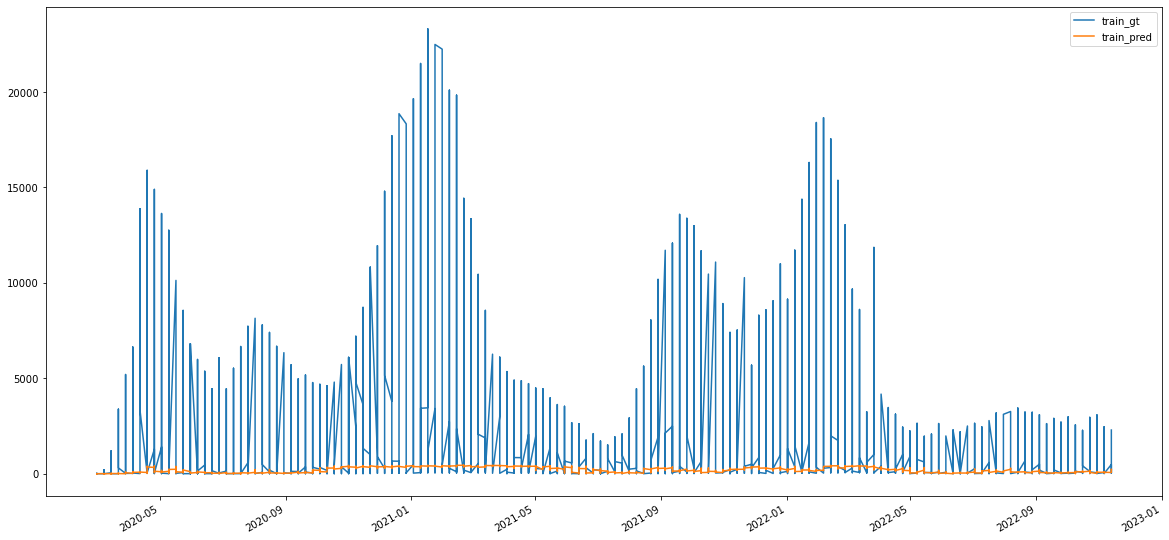

In [ ]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 5ms/step


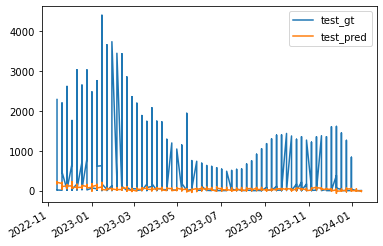

In [ ]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [ ]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [ ]:
mae = mean_absolute_error(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
r2 = r2_score(test_gt, test_pred)
new_row = {'model': '1', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 2

## Training

In [ ]:
learning_rate = 0.001
batch_size = 16
epochs = 50
sequence_length =13

In [ ]:
inputs = keras.layers.Input(shape=(13,67))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12800     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 67)
(14136,)
Epoch 1/50
884/884 [==============================] - 24s 21ms/step - loss: 1115.8174
Epoch 2/50
884/884 [==============================] - 21s 24ms/step - loss: 1103.7662
Epoch 3/50
884/884 [==============================] - 17s 19ms/step - loss: 1097.7676
Epoch 4/50
884/884 [==============================] - 20s 22ms/step - loss: 1094.1387
Epoch 5/50
884/884 [==============================] - 19s 21ms/step - loss: 1091.3588
Epoch 6/50
884/884 [==============================] - 20s 22ms/step - loss: 1088.4966
Epoch 7/50
884/884 [==============================] - 16s 18ms/step - loss: 1085.9580
Epoch 8/50
884/884 [==============================] - 19s 22ms/step - loss: 1083.6890
Epoch 9/50
884/884 [==============================] - 15s 16ms/step - loss: 1081.7870
Epoch 10/50
884/884 [==============================] - 13s 15ms/step - loss: 1080.1547
Epoch 11/50
884/884 [==============================] - 13s 15ms/step - loss: 1078.7354
Epoch 12/50
884/884 [======

## Testing

In [ ]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 4s 6ms/step


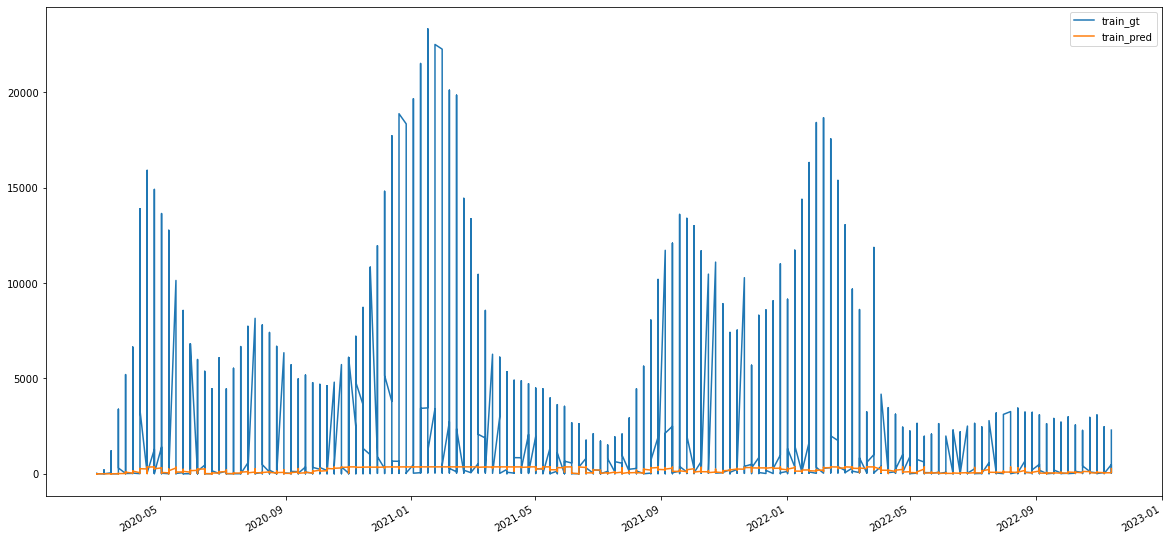

In [ ]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 4ms/step


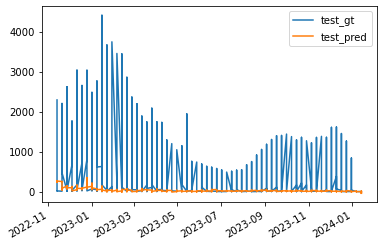

In [ ]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [ ]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [ ]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '2', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 3

## Training

In [ ]:
learning_rate = 0.001
batch_size = 16
epochs = 50
sequence_length =13

In [ ]:
inputs = keras.layers.Input(shape=(13,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(32)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 64)            33792     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 67)
(14136,)
Epoch 1/50
884/884 [==============================] - 30s 28ms/step - loss: 1116.1667
Epoch 2/50
884/884 [==============================] - 26s 30ms/step - loss: 1104.5099
Epoch 3/50
884/884 [==============================] - 27s 30ms/step - loss: 1098.4277
Epoch 4/50
884/884 [==============================] - 26s 30ms/step - loss: 1096.1378
Epoch 5/50
884/884 [==============================] - 26s 30ms/step - loss: 1093.9913
Epoch 6/50
884/884 [==============================] - 26s 30ms/step - loss: 1092.3010
Epoch 7/50
884/884 [==============================] - 28s 31ms/step - loss: 1090.0564
Epoch 8/50
884/884 [==============================] - 27s 31ms/step - loss: 1086.7601
Epoch 9/50
884/884 [==============================] - 27s 30ms/step - loss: 1084.3435
Epoch 10/50
884/884 [==============================] - 27s 31ms/step - loss: 1082.4513
Epoch 11/50
884/884 [==============================] - 27s 31ms/step - loss: 1080.6168
Epoch 12/50
884/884 [======

## Testing

In [ ]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 6s 9ms/step


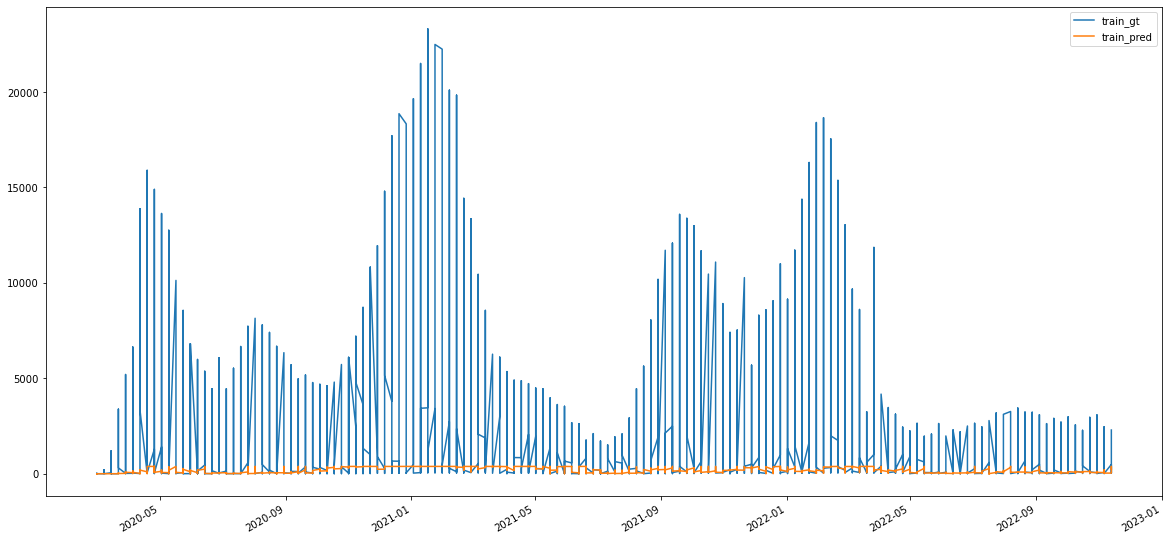

In [ ]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 5ms/step


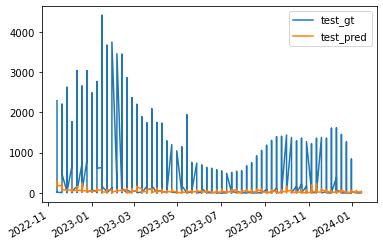

In [ ]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [ ]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [ ]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '3', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 4

## Training

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
batch_size = 16
epochs = 50
sequence_length =13

In [ ]:
inputs = keras.layers.Input(shape=(13,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 14, 64)            33792     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 67)
(14136,)
Epoch 1/50
884/884 [==============================] - 44s 40ms/step - loss: 1115.3677
Epoch 2/50
884/884 [==============================] - 37s 42ms/step - loss: 1103.7233
Epoch 3/50
884/884 [==============================] - 38s 43ms/step - loss: 1097.9526
Epoch 4/50
884/884 [==============================] - 39s 44ms/step - loss: 1094.6610
Epoch 5/50
884/884 [==============================] - 38s 43ms/step - loss: 1091.9054
Epoch 6/50
884/884 [==============================] - 39s 44ms/step - loss: 1089.0972
Epoch 7/50
884/884 [==============================] - 38s 43ms/step - loss: 1086.6942
Epoch 8/50
884/884 [==============================] - 37s 42ms/step - loss: 1084.3600
Epoch 9/50
884/884 [==============================] - 37s 42ms/step - loss: 1082.4929
Epoch 10/50
884/884 [==============================] - 38s 42ms/step - loss: 1080.9348
Epoch 11/50
884/884 [==============================] - 38s 43ms/step - loss: 1079.4219
Epoch 12/50
884/884 [======

## Testing

In [ ]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 6s 11ms/step


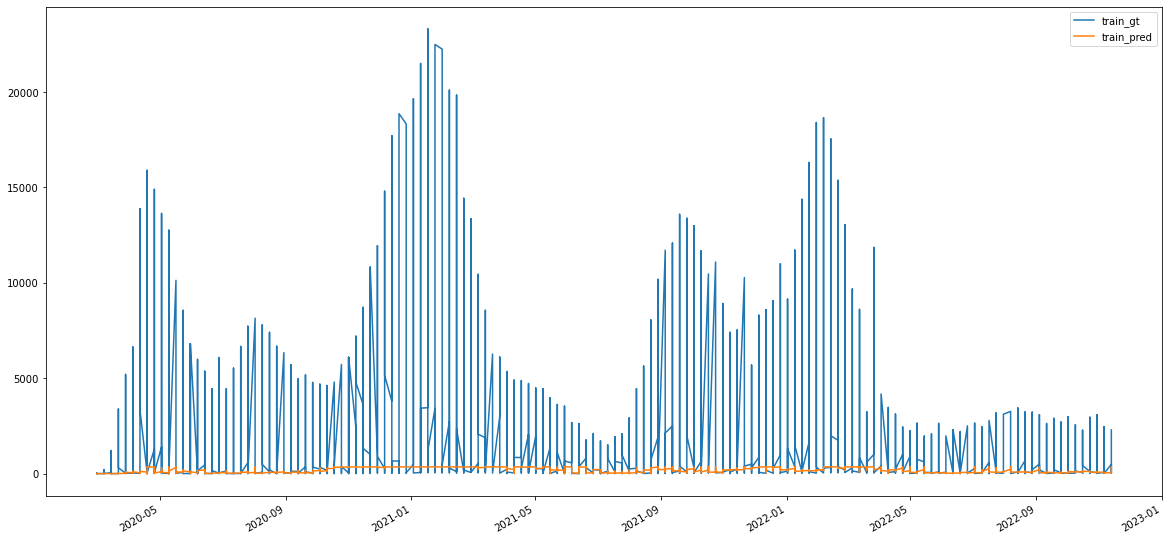

In [ ]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 2s 9ms/step


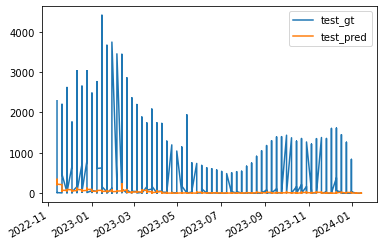

In [ ]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [ ]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [ ]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '4', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 5

## Training

In [ ]:
learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
batch_size = 16
epochs = 50
sequence_length =13

In [ ]:
inputs = keras.layers.Input(shape=(13,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            33792     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

(14136, 14, 67)
(14136,)
Epoch 1/50
707/707 [==============================] - 43s 44ms/step - loss: 1297.9696 - val_loss: 400.6448
Epoch 2/50
707/707 [==============================] - 31s 43ms/step - loss: 1286.5690 - val_loss: 389.5126
Epoch 3/50
707/707 [==============================] - 30s 42ms/step - loss: 1279.1908 - val_loss: 387.0978
Epoch 4/50
707/707 [==============================] - 30s 42ms/step - loss: 1274.4771 - val_loss: 387.5976
Epoch 5/50
707/707 [==============================] - 31s 43ms/step - loss: 1270.9657 - val_loss: 388.4032
Epoch 6/50
707/707 [==============================] - 31s 43ms/step - loss: 1267.2424 - val_loss: 390.5355
Epoch 7/50
707/707 [==============================] - 30s 43ms/step - loss: 1265.4518 - val_loss: 390.0380
Epoch 8/50
707/707 [==============================] - 30s 43ms/step - loss: 1262.9946 - val_loss: 391.2697


## Testing

In [ ]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 5s 9ms/step


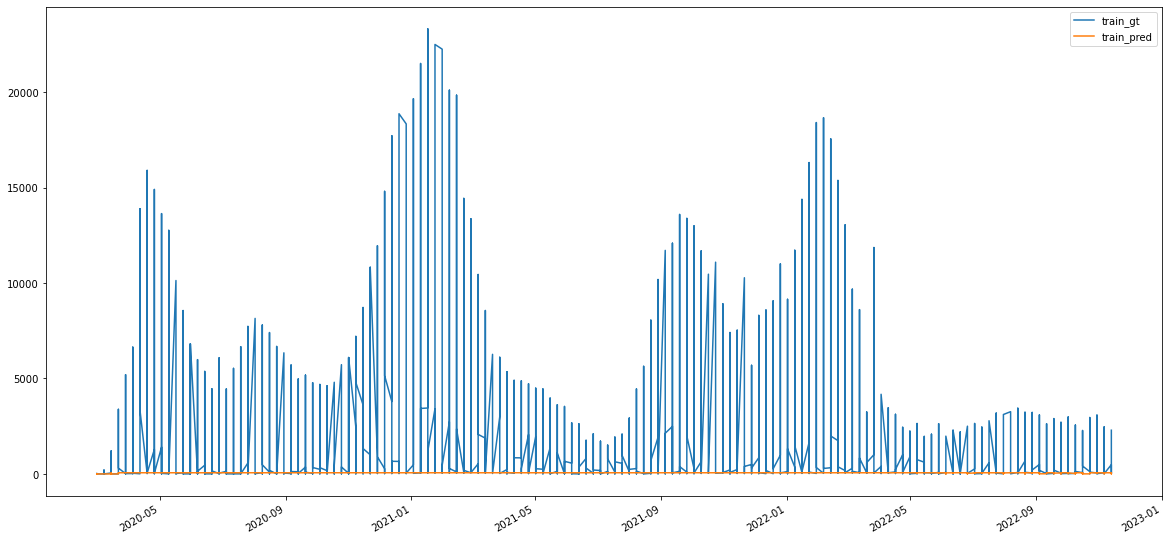

In [ ]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 2s 8ms/step


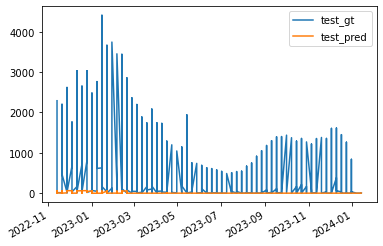

In [ ]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [ ]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [ ]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '5', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Results

In [ ]:
metrics

,model,mae,mase,rsq
0,1,214.955821,0.290945,-0.084962
1,2,211.253384,0.285934,-0.104374
2,3,215.310887,0.291426,-0.091692
3,4,209.644786,0.283757,-0.09912
4,5,213.220753,0.288597,-0.132574


In [ ]:
metrics.sort_values('mase')

,model,mae,mase,rsq
3,4,209.644786,0.283757,-0.09912
1,2,211.253384,0.285934,-0.104374
4,5,213.220753,0.288597,-0.132574
0,1,214.955821,0.290945,-0.084962
2,3,215.310887,0.291426,-0.091692
